In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os
sys.path.insert(0, 'models')
sys.path.insert(0, 'utils')
# from yukun_disentanglement_lib.data.ground_truth import celeba, celebaHR
from dsvae_model_large_HR_no_enc_no_y import DSVAELHR, loss_function
from datasets import DATA_HR
import celebaHR
import numpy as np
import time, math
from misc import merge
import argparse
import wandb
import matplotlib.pyplot as plt
import numpy as np
import torch
torch.manual_seed(0)
np.random.seed(0);

In [2]:
log = True
if log:
    wandb.init(project="pytorch_dsvae_hr", name="celeba_dsvae_10k_HR_no_enc_no_y")

# Load the data

In [3]:
parser = argparse.ArgumentParser()
parser.add_argument("--z_dim", help="z dimension", default=85, type=int)
parser.add_argument("--device", help="gpu id", default=1, type=int)
parser.add_argument("--nb_epochs", help="number of epochs", default=500, type=int)
parser.add_argument("--lr", help="learning rate", default=.0001, type=float)
parser.add_argument("--batch_size", help="batch size", default=100, type=int)
args = parser.parse_args([])

if log:
    wandb.config.update(args)

device = args.device
print("z_dim: {}".format(args.z_dim))
print("GPU: {}".format(device))

num_samples=12000
path_to_celebA = "../dsvae/yukun_disentanglement_lib/img_align_celeba"
dtahr = celebaHR.CelebAHR(celeba_path=path_to_celebA, num_samples=num_samples, res=128)

wandb: Wandb version 0.8.29 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


z_dim: 85
GPU: 1
12000
finish reading face images
(12000, 128, 128, 3)


In [4]:
inputs_hr = np.float32(dtahr.images[:10000])
validation_hr = np.float32(dtahr.images[10000:])
torch_inputs_hr = torch.from_numpy(inputs_hr).permute(0,3,1,2)
torch_validation_hr = torch.from_numpy(validation_hr).permute(0,3,1,2)

In [5]:
torch_dataset = DATA_HR(torch_inputs_hr)
torch_data_loader = torch.utils.data.DataLoader(torch_dataset, batch_size=args.batch_size, shuffle=True)

torch_validation_dataset = DATA_HR(torch_validation_hr)
torch_validation_loader = torch.utils.data.DataLoader(torch_validation_dataset, batch_size=args.batch_size, shuffle=False)


In [6]:
def plot_pytorch_images(images, num_images=5, title=""):
    images = images.detach()
    if images.is_cuda:
        images = images.cpu()
    images = images.permute(0,2,3,1)
    img = np.expand_dims(images,0)
    img = merge(img[0],[1,num_images])
    fig = plt.figure(figsize=(8*max(1, num_images-2),8))
    plt.imshow(img)
    plt.gray()
    plt.title(title)
    plt.show()
    return fig

In [7]:
if args.device != -1:
    dsvae = DSVAELHR(z_dim=85, device=args.device)
    dsvae.to(device)
else:
    dsvae = DSVAELHR(z_dim=85, device=None)
optimizer = torch.optim.Adam(params=dsvae.parameters(), lr=args.lr)

# Define the DSVAE model

Training for 1500 epochs...


wandb: Wandb version 0.8.29 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


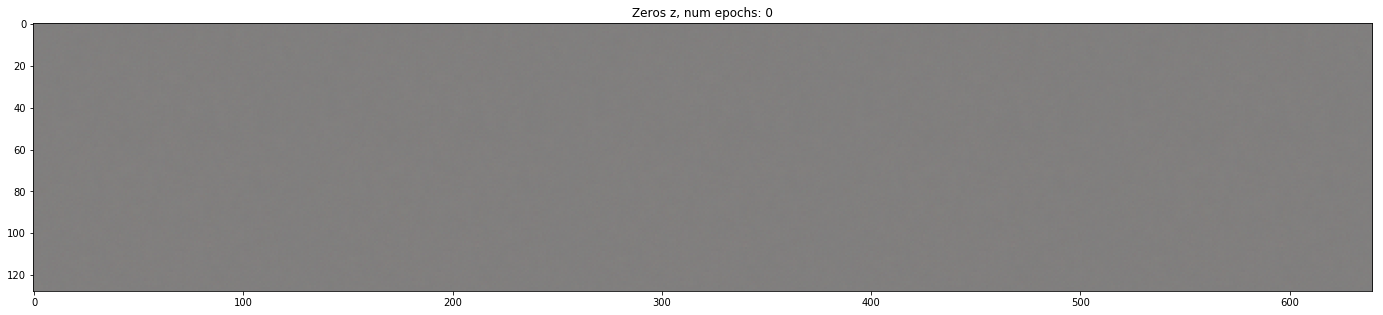

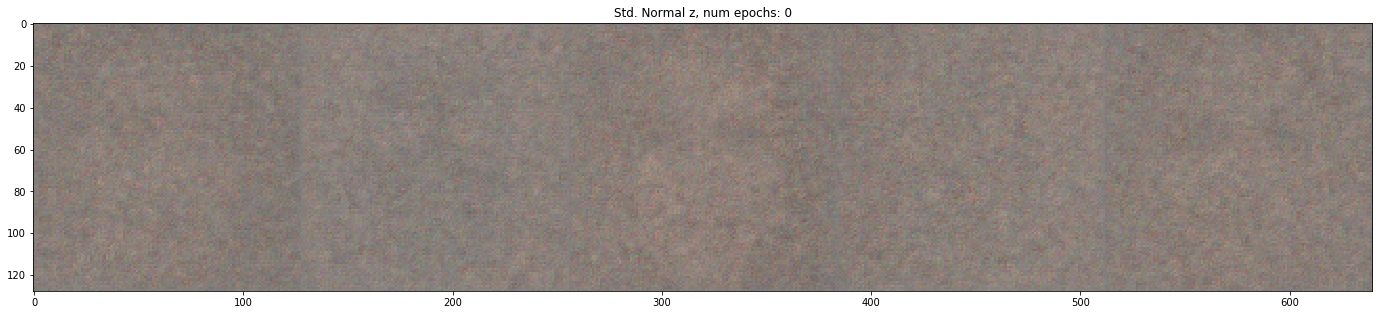

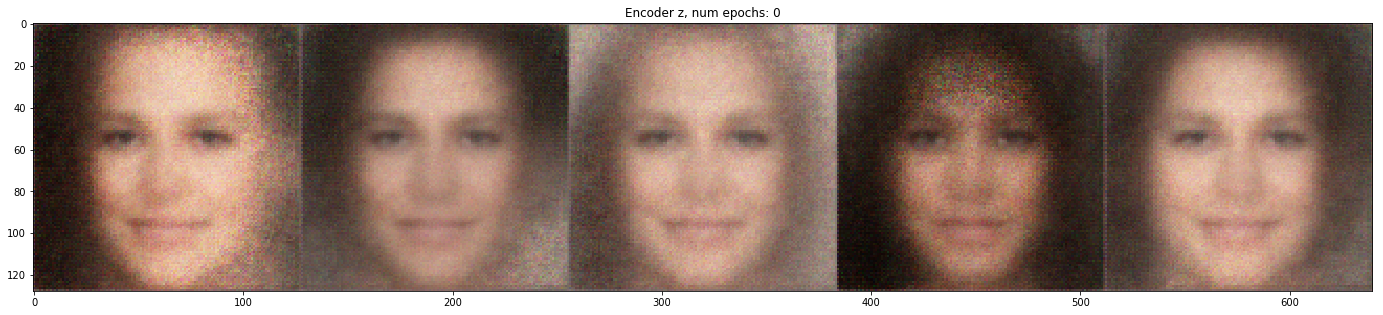

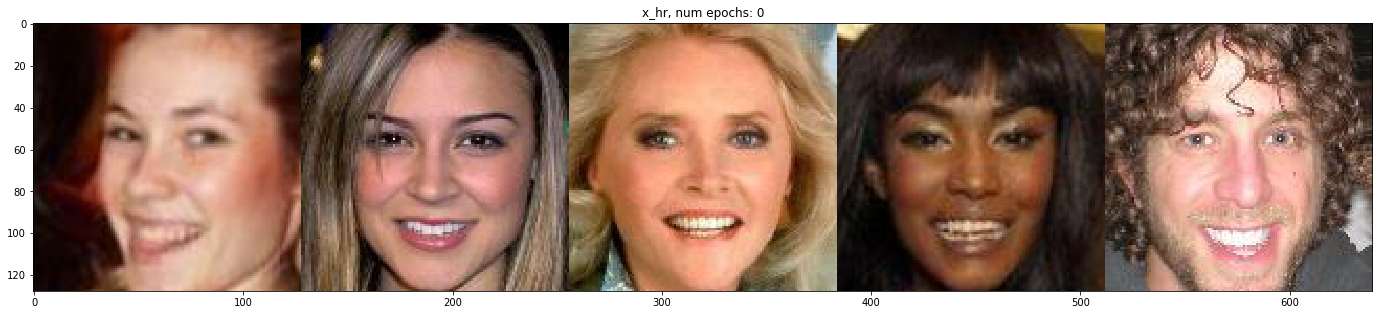

In [ ]:
dsvae.train()
normal = torch.distributions.Normal(0,1)
print("Training for {} epochs...".format(1500))
for n in range(0, 1000):
    train_loss = 0
    train_recon_loss = 0
    train_kl_loss = 0
    num_examples = 0
    for (i, X) in enumerate(torch_data_loader):
        x_hr = X
        if dsvae.cuda:
            x_hr = x_hr.to(device)
        optimizer.zero_grad()
        x_hr_hat, z_mu, z_var = dsvae(x_hr)
        loss, recon_loss, kl_loss = loss_function(x_hr_hat, x_hr, z_mu, z_var)
        train_loss += loss.item()
        train_recon_loss += recon_loss.item()
        train_kl_loss += kl_loss.item()
        num_examples += x_hr.shape[0]
        loss.backward()
        optimizer.step()
    if log:
        wandb.log({'train_loss':train_loss/num_examples})
        wandb.log({'train_recon_loss':train_recon_loss/num_examples})
        wandb.log({'train_kl_loss':train_kl_loss/num_examples})
    
    dsvae.eval()
    validation_loss = 0
    validation_recon_loss = 0
    validation_kl_loss = 0
    num_examples = 0
    for (j, X) in enumerate(torch_validation_loader):
        x_hr = X
        if dsvae.cuda:
            x_hr = x_hr.to(device)
        optimizer.zero_grad()
        x_hr_hat, z_mu, z_var = dsvae(x_hr)
        loss, recon_loss, kl_loss = loss_function(x_hr_hat, x_hr, z_mu, z_var)
        validation_loss += loss.item()
        validation_recon_loss += recon_loss.item()
        validation_kl_loss += kl_loss.item()
        num_examples += x_hr.shape[0]
        loss.backward()
        optimizer.step()
    if log:
        wandb.log({'validation_loss':validation_loss/num_examples})
        wandb.log({'validation_recon_loss':validation_recon_loss/num_examples})
        wandb.log({'validation_kl_loss':validation_kl_loss/num_examples})

    if n%50 ==0:
        dsvae.eval() #evaluate model
        rand_indices = np.random.randint(0,len(torch_validation_dataset), 5)
        z_noise = normal.sample((5,85))
        z_zeros = torch.zeros((5,85))
        x_hr = torch_validation_dataset[rand_indices]
        
        if dsvae.cuda:
            z_noise = z_noise.to(device)
            z_zeros = z_zeros.to(device)
            x_hr = x_hr.to(device)
            
        x_hat_noise = dsvae.decode(z_noise)
        x_hat_zeros = dsvae.decode(z_zeros)
        x_hr_hat, _, _ = dsvae(x_hr)
        
        fig = plot_pytorch_images(x_hat_zeros, num_images=5, title='Zeros z, num epochs: {}'.format(n))
        if log:
            wandb.log({'Sample from zero':fig})
            
        fig = plot_pytorch_images(x_hat_noise, num_images=5, title='Std. Normal z, num epochs: {}'.format(n))
        if log:
            wandb.log({'Samples from prior':fig})
            
        fig = plot_pytorch_images(x_hr_hat, num_images=5, title='Encoder z, num epochs: {}'.format(n))
        if log:
            wandb.log({'Samples from posterior':fig})
            
        fig = plot_pytorch_images(x_hr, num_images=5, title='x_hr, num epochs: {}'.format(n))
        if log:
            wandb.log({'X high res':fig})
        dsvae.train()

In [ ]:
dsvae.eval()
y = torch.distributions.Normal(0,1).sample(torch_dataset[0:100].shape)
x_hat, z_mu, z_var = dsvae(y.to(device), torch_dataset[0:100].to(device))

from IPython.display import clear_output
for z in np.linspace(z_mu[99].detach().cpu().numpy(),z_mu[77].detach().cpu().numpy()):
    clear_output(wait=True)
    z = torch.from_numpy(z).unsqueeze(0).to(device)
    x_hat = dsvae.decode(torch.distributions.Normal(0,1).sample((1,3,128,128)).to(device), z)
    plot_pytorch_images(x_hat, num_images=1);

In [ ]:
dsvae.eval()
y = torch.distributions.Normal(0,1).sample(torch_dataset[0:5].shape)
x_hat, z_mu, z_var = dsvae(y.to(device), torch_dataset[0:5].to(device))

from scipy.stats import norm
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(18,5))
idx = 4
x_axis = np.arange(-5, 5, 0.001)
for idx in range(0,5):
    ax = axes[idx]
    for i, mu in enumerate(z_mu[idx]):
        ax.plot(x_axis, norm.pdf(x_axis, mu.detach().cpu().numpy(), torch.sqrt(z_var[idx][i]).detach().cpu().numpy()), alpha=.5)
    ax.plot(x_axis, norm.pdf(x_axis, 0,1))
    if idx > 0:
        ax.set_yticks([],[])
plt.show()
plot_pytorch_images(x_hat, num_images=5);

In [ ]:
dsvae.eval()
y = torch.distributions.Normal(0,1).sample(torch_dataset[0:5].shape)
x_hat, z_mu, z_var = dsvae(y.to(device), torch_dataset[0:5].to(device))
plot_pytorch_images(x_hat, num_images=5);
noise = torch.distributions.Normal(0, 1).sample((5,3,128,128)).to(device)
x_hat_sample = dsvae.decode(noise, torch.distributions.Normal(z_mu, z_var).sample())
plot_pytorch_images(x_hat, num_images=5);

In [ ]:
dsvae.eval()
dsvae.cpu()
dsvae.device = None
y = torch.distributions.Normal(0,1).sample(torch_dataset[:1000].shape)
x_hr_hat, z_mu, z_var = dsvae(y, torch_dataset[:1000])
z_sample = torch.distributions.Normal(z_mu, z_var).sample()
z_sample_avg = torch.mean(z_sample, 0)
z_sample_std = torch.std(z_sample, 0)

In [ ]:
plt.scatter(range(85), z_sample_avg.detach().cpu().numpy())
plt.scatter(range(85), z_sample_std.detach().cpu().numpy())

In [ ]:
mu = z_sample_avg.detach()
std = z_sample_std.detach()

x_hat = dsvae.decode(torch.distributions.Normal(0,1).sample((1,3,128,128)), torch.distributions.Normal(mu, std).sample())
plot_pytorch_images(x_hat.to(device), num_images=1);

In [ ]:
plt.hist(torch.distributions.Normal(0,1).sample((1,100))[0],bins=30)
mu = torch.mean(z_sample_avg).detach().cpu()
std = torch.mean(z_sample_std.detach()).cpu()
plt.hist(torch.distributions.Normal(mu,std).sample((1,100))[0], bins=30);
print(torch.distributions.kl_divergence(torch.distributions.Normal(mu,std), torch.distributions.Normal(0,1)))